# INFO 2950 Final Project Phase 2

Group: Franklin Zheng, Felix Roz, Pratham Rawat


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Research Overview / Questions

We want to analyze Senate stock filings. By pairing this data with datasets containing data on those senators, we hope to find interesting relationships between Senators' characteristics/features and their stock filings.

Some questions we want to consider are:
- Do Senators perform better than the market?
- Do Senators make timely trades based off of government or electoral decisions?
- How do the trading habits of Senators differ across various features (political party, gender, etc)?


### Data Collection

#### SEC Filing Data

The main dataset of SEC filings is pulled from [Senate Stock Watcher](https://senatestockwatcher.com/api) which provides an API for following Senator's stock trades. By law, officeholding members of the government have to disclose every stock trade that they make to the Securities and Exchange Commission. By following these trades, we hope to find some interesting results. The site offers a realtime API that updates every time an SEC filing is made. However, it also offers historical data in a downloadable CSV format, which is what we are using for our analysis.

#### Stock Market Historical Prices

For data on the tickers that we want to analyze throughout the stock filings, we will use data from [Google Finance](https://support.google.com/docs/answer/3093281?hl=en) to get historical stock prices to try to gauge how successful an investment in a particular stock was. Google Sheets provides an integration for Google Finance which allows us to get stock prices for a particular company in a given date range. We would use this to analyze particular stocks of interest and how senators performed in their investments of those stocks.

#### Additional Senator Data

We will use [the @unitedstates project](https://github.com/unitedstates/congress-legislators) to get broad data on every single senator for certain datapoints. These all provide downloadable CSVs which we can use to cross-reference senator names from the SEC Filing data to get different features of those senators. However, we will need to download two datasets. One of historical data and one of current data. We can also prune down this dataset intensely in order to only contain senators that have filed with the SEC, instead of all legislators since the 1700s.

### Data Cleaning

#### SEC Filings

First, we need to load the data. We can print it out, so we get an understanding of datapoints available to us.

In [2]:
data = pd.read_csv("data/raw/all_transactions.csv") # senate
house = pd.read_csv("data/raw/all_transactions_house.csv") # house
data.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
0,01/16/2021,Joint,--,Fitso (Exchanged) <br> Zomato (Received) <div ...,Non-Public Stock,Exchange,"$1,001 - $15,000",Exchange of stock due to merger. Asset is unde...,Patrick J Toomey,https://efdsearch.senate.gov/search/view/ptr/4...,09/09/2021
1,08/30/2021,Joint,CALX,"Calix, Inc Common Stock <div class=""text-muted...",Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/d...,09/08/2021
2,08/30/2021,Joint,ECOM,ChannelAdvisor Corporation Common Stock <div c...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/d...,09/08/2021
3,08/30/2021,Joint,ECOM,ChannelAdvisor Corporation Common Stock <div c...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/d...,09/08/2021
4,08/27/2021,Joint,CALX,"Calix, Inc Common Stock <div class=""text-muted...",Stock Option,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/d...,09/08/2021


We can see that some of the data in the `ticker` column has a value of `--`. We can also see a lot of columns that we do not want to operate on. We can remove those datapoints and columns.

We are also removing the rows that contain data about other kinds of financial securities like `Stock Option`. We won't be focusing on those securities in our analysis.

In [3]:
data = data.loc[data.asset_type == "Stock"].loc[data.ticker != "--"].dropna()
data = data.drop(columns=["ptr_link", "asset_type", "disclosure_date", "asset_description"])
data.head()

,transaction_date,owner,ticker,type,amount,comment,senator
5,08/18/2021,Joint,SSYS,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville
6,08/12/2021,Joint,SSBK,Purchase,"$50,001 - $100,000",--,Thomas H Tuberville
19,08/23/2021,Spouse,LMRK,Sale (Full),"$1,001 - $15,000",--,Thomas R Carper
22,08/11/2021,Spouse,WW,Purchase,"$1,001 - $15,000",--,Thomas R Carper
23,08/04/2021,Spouse,ARE,Sale (Partial),"$1,001 - $15,000",--,Thomas R Carper


Let's look at the datatypes for the columns:

In [4]:
data.dtypes

transaction_date    object
owner               object
ticker              object
type                object
amount              object
comment             object
senator             object
dtype: object

Everything is an object! The two columns that stick out here are the columns for `amount` and the comments for `transaction_date`. We can save the `trasaction_date` column as a python `datetime` object. We can also split up the date object into columns for year, month, and day.

In [5]:
data["transaction_date"] = pd.to_datetime(data["transaction_date"])
data['transaction_year'] = pd.DatetimeIndex(data['transaction_date']).year
data['transaction_month'] = pd.DatetimeIndex(data['transaction_date']).month
data['transaction_day'] = pd.DatetimeIndex(data['transaction_date']).day
data.sort_values("transaction_date", ascending=False).head()

,transaction_date,owner,ticker,type,amount,comment,senator,transaction_year,transaction_month,transaction_day
19,2021-08-23,Spouse,LMRK,Sale (Full),"$1,001 - $15,000",--,Thomas R Carper,2021,8,23
5,2021-08-18,Joint,SSYS,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,2021,8,18
6,2021-08-12,Joint,SSBK,Purchase,"$50,001 - $100,000",--,Thomas H Tuberville,2021,8,12
22,2021-08-11,Spouse,WW,Purchase,"$1,001 - $15,000",--,Thomas R Carper,2021,8,11
23,2021-08-04,Spouse,ARE,Sale (Partial),"$1,001 - $15,000",--,Thomas R Carper,2021,8,4


While the `amount` column contains a range of value that the stock trade was in, we can split up the column into numerical columns of the upper and lower bound of the trade. This allows us to do numerical analysis on this data without choosing a non-canonical value within the range.

In [6]:
# over thing is bad. think about this more and fix it
data["amount_lower"] = pd.to_numeric(data["amount"].replace("Over ","",regex=True).replace("\$", "", regex=True).replace(" -.*$", "", regex=True).replace(",", "", regex=True))
data["amount_upper"] = pd.to_numeric(data["amount"].replace("Over ","",regex=True).replace(".* - ", "", regex=True).replace("\$", "", regex=True).replace(",", "", regex=True))
data.head()

,transaction_date,owner,ticker,type,amount,comment,senator,transaction_year,transaction_month,transaction_day,amount_lower,amount_upper
5,2021-08-18,Joint,SSYS,Purchase,"$1,001 - $15,000",--,Thomas H Tuberville,2021,8,18,1001,15000
6,2021-08-12,Joint,SSBK,Purchase,"$50,001 - $100,000",--,Thomas H Tuberville,2021,8,12,50001,100000
19,2021-08-23,Spouse,LMRK,Sale (Full),"$1,001 - $15,000",--,Thomas R Carper,2021,8,23,1001,15000
22,2021-08-11,Spouse,WW,Purchase,"$1,001 - $15,000",--,Thomas R Carper,2021,8,11,1001,15000
23,2021-08-04,Spouse,ARE,Sale (Partial),"$1,001 - $15,000",--,Thomas R Carper,2021,8,4,1001,15000


We are leaving the `comment` column in as it contains some pertinent data that the senators have added in about the trade. But now, the data is clean, and ready for us to conduct some basic analyses of it!

#### Legislator Data


First we load the dataset.

In [7]:
legislators_current = pd.read_csv("data/raw/legislators-current.csv")
legislators_historical = pd.read_csv("data/raw/legislators-historical.csv")

Now we can append the datasets together into one large dataset.

In [8]:
legislators = legislators_historical.append(legislators_current)
legislators.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,...,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Bassett,Richard,NaN,NaN,NaN,NaN,1745-04-02,M,sen,DE,...,NaN,NaN,NaN,NaN,401222,NaN,NaN,NaN,507.0,Richard Bassett (Delaware politician)
1,Bland,Theodorick,NaN,NaN,NaN,NaN,1742-03-21,M,rep,VA,...,NaN,NaN,NaN,NaN,401521,NaN,NaN,NaN,786.0,Theodorick Bland (congressman)
2,Burke,Aedanus,NaN,NaN,NaN,NaN,1743-06-16,M,rep,SC,...,NaN,NaN,NaN,NaN,402032,NaN,NaN,NaN,1260.0,Aedanus Burke
3,Carroll,Daniel,NaN,NaN,NaN,NaN,1730-07-22,M,rep,MD,...,NaN,NaN,NaN,NaN,402334,NaN,NaN,NaN,1538.0,Daniel Carroll
4,Clymer,George,NaN,NaN,NaN,NaN,1739-03-16,M,rep,PA,...,NaN,NaN,NaN,NaN,402671,NaN,NaN,NaN,1859.0,George Clymer


This dataset contains a lot of data that we don't need. First, lets isolate the columns that we are interested in.

In [9]:
legislators = legislators[["last_name", "first_name", "middle_name", "gender", "type", "party", "state", "district", "senate_class"]]
legislators.head()

,last_name,first_name,middle_name,gender,type,party,state,district,senate_class
0,Bassett,Richard,NaN,M,sen,Anti-Administration,DE,NaN,2.0
1,Bland,Theodorick,NaN,M,rep,NaN,VA,9.0,NaN
2,Burke,Aedanus,NaN,M,rep,NaN,SC,2.0,NaN
3,Carroll,Daniel,NaN,M,rep,NaN,MD,6.0,NaN
4,Clymer,George,NaN,M,rep,NaN,PA,-1.0,NaN


Let's also split up the dataset into senators and representatives.

In [10]:
senators = legislators[legislators['type'] == "sen"]
print(senators.head())
representatives = legislators[legislators['type'] == "rep"]
print(representatives.head())

   last_name first_name middle_name gender type                party state  \
0    Bassett    Richard         NaN      M  sen  Anti-Administration    DE   
6     Dalton   Tristram         NaN      M  sen   Pro-Administration    MA   
7      Elmer   Jonathan         NaN      M  sen   Pro-Administration    NJ   
8        Few    William         NaN      M  sen  Anti-Administration    GA   
11   Grayson    William         NaN      M  sen  Anti-Administration    VA   

    district  senate_class  
0        NaN           2.0  
6        NaN           1.0  
7        NaN           1.0  
8        NaN           2.0  
11       NaN           1.0  
  last_name  first_name middle_name gender type party state  district  \
1     Bland  Theodorick         NaN      M  rep   NaN    VA       9.0   
2     Burke     Aedanus         NaN      M  rep   NaN    SC       2.0   
3   Carroll      Daniel         NaN      M  rep   NaN    MD       6.0   
4    Clymer      George         NaN      M  rep   NaN    PA      

In order to search for legislators by name, we need to put the name in the same format as what is used in the stock-watcher dataset.

Some of the senators have issues with titles and nicknames. These senators had to be painstakingly pieced together by hand. Thankfully, it was not many of them.

In [11]:
senators["name"] = pd.DataFrame.copy(senators.apply(lambda r: "{}{}{}".format(r["first_name"], " " if pd.isna(r["middle_name"]) else " {} ".format(r["middle_name"][0]), r["last_name"]), axis=1))

senators.loc[senators["name"] == "Angus S King", "name"] = "Angus S King, Jr."
senators.loc[senators["name"] == "Tommy H Tuberville", "name"] = "Thomas H Tuberville"
senators.loc[senators["name"] == "Bill F Hagerty", "name"] = "William F Hagerty, Iv"
senators.loc[senators["name"] == "Mitch McConnell", "name"] = "A. Mitchell Mcconnell, Jr."
senators.loc[senators["name"] == "Jerry Moran", "name"] = "Jerry Moran,"
senators.loc[senators["name"] == "Ron Wyden", "name"] = "Ron L Wyden"
senators.loc[senators["name"] == "Dan Sullivan", "name"] = "Daniel S Sullivan"
senators.loc[senators["name"] == "Jacky Rosen", "name"] = "Jacklyn S Rosen"
senators.loc[senators["name"] == "Bill Cassidy", "name"] = "William Cassidy"
senators.loc[senators["name"] == "Timothy Kaine", "name"] = "Timothy M Kaine"
senators.loc[senators["name"] == "David Perdue", "name"] = "David A Perdue , Jr"
senators.loc[senators["name"] == "Tina F Smith", "name"] = "Tina Smith"
senators.loc[senators["name"] == "Ted Cruz", "name"] = "Rafael E Cruz"
senators.loc[senators["name"] == "Tom S Udall", "name"] = "Thomas Udall"
senators.loc[senators["name"] == "Thom Tillis", "name"] = "Thomas R Tillis"
senators.loc[senators["name"] == "Robert P Casey", "name"] = "Robert P Casey, Jr."
senators.loc[senators["name"] == "Joe Manchin", "name"] = "Joseph Manchin, Iii"

print(senators.head())

representatives["name"] = pd.DataFrame.copy(representatives.apply(lambda r: "{}{}{}".format(r["first_name"], " " if pd.isna(r["middle_name"]) else " {} ".format(r["middle_name"][0]), r["last_name"]), axis=1))
print(representatives.head())

   last_name first_name middle_name gender type                party state  \
0    Bassett    Richard         NaN      M  sen  Anti-Administration    DE   
6     Dalton   Tristram         NaN      M  sen   Pro-Administration    MA   
7      Elmer   Jonathan         NaN      M  sen   Pro-Administration    NJ   
8        Few    William         NaN      M  sen  Anti-Administration    GA   
11   Grayson    William         NaN      M  sen  Anti-Administration    VA   

    district  senate_class             name  
0        NaN           2.0  Richard Bassett  
6        NaN           1.0  Tristram Dalton  
7        NaN           1.0   Jonathan Elmer  
8        NaN           2.0      William Few  
11       NaN           1.0  William Grayson  


/Users/prathamrawat/git/2950-Final/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/prathamrawat/git/2950-Final/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  last_name  first_name middle_name gender type party state  district  \
1     Bland  Theodorick         NaN      M  rep   NaN    VA       9.0   
2     Burke     Aedanus         NaN      M  rep   NaN    SC       2.0   
3   Carroll      Daniel         NaN      M  rep   NaN    MD       6.0   
4    Clymer      George         NaN      M  rep   NaN    PA      -1.0   
5    Contee    Benjamin         NaN      M  rep   NaN    MD       3.0   

   senate_class              name  
1           NaN  Theodorick Bland  
2           NaN     Aedanus Burke  
3           NaN    Daniel Carroll  
4           NaN     George Clymer  
5           NaN   Benjamin Contee  


/Users/prathamrawat/git/2950-Final/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now we should be able to search for legislators using the data from the SEC. 

Not really! The function used here has a few conditionals to change a few names that are irregularly used in the data. For example, Tammy Duckworth goes by both `Tammy Duckworth` and `Ladda Tammy Duckworth`.

But with this, we can now isolate the senators that appear in the senate data, and cross-reference the data to do some analysis.

In [12]:
def get_senator(name):
  if name == "Ladda Tammy Duckworth":
    name = "Tammy Duckworth"
  if name == "Michael  B Enzi":
    name = "Michael B Enzi"
  return indexed_senators.loc[name]

indexed_senators = senators.set_index("name")
indexed_senators["name"] = indexed_senators.index
trading_senators = data["senator"].apply(get_senator)
trading_senators = trading_senators.drop_duplicates()
trading_senators = trading_senators.reset_index()
trading_senators = trading_senators.drop("index", axis=1)
trading_senators.head()

,last_name,first_name,middle_name,gender,type,party,state,district,senate_class,name
0,Tuberville,Tommy,Hawley,M,sen,Republican,AL,NaN,2.0,Thomas H Tuberville
1,Carper,Thomas,Richard,M,sen,Democrat,DE,NaN,1.0,Thomas R Carper
2,Capito,Shelley,Moore,F,sen,Republican,WV,NaN,2.0,Shelley M Capito
3,Hickenlooper,John,Wright,M,sen,Democrat,CO,NaN,2.0,John W Hickenlooper
4,Peters,Gary,C.,M,sen,Democrat,MI,NaN,2.0,Gary C Peters


Having already imported the House CSV file alongside the Senate data, we can immediately begin cleaning the data. While converting the `transaction_date` column to `Datetime` object, we came across several misformatted dates that threw an error! Using regex, we were able to identify the bogus data and their indexes for manual removal and begin reformatting all the dates, upper, and lower values.

In [13]:
# bad years
#   $ cut -d',' -f3 all_transactions_house.csv | grep -nv '^2'
#   1:transaction_date
#   1958:0009-06-09
#   3383:0021-08-02
#   8977:0021-06-22
#   8978:0201-06-22
house = house.drop([1956,3381,8975,8976]) 

# bad tickers
house = house.loc[house.ticker != "--"].dropna()

# dropping unneeded columns
house = house.drop(columns=["ptr_link", "disclosure_date", "disclosure_year", "asset_description"])

In [14]:
house['transaction_date'] = pd.to_datetime(house['transaction_date'])
house['transaction_year'] = pd.DatetimeIndex(house['transaction_date']).year
house['transaction_month'] = pd.DatetimeIndex(house['transaction_date']).month
house['transaction_day'] = pd.DatetimeIndex(house['transaction_date']).day
house["amount_lower"] = pd.to_numeric(house["amount"].replace("Over ","",regex=True).replace("\$", "", regex=True).replace(" -.*$", "", regex=True).replace(",", "", regex=True))
house["amount_upper"] = pd.to_numeric(house["amount"].replace("Over ","",regex=True).replace("-$", "- 0", regex=True).replace(".* - ", "", regex=True).replace("\$", "", regex=True).replace(",", "", regex=True))
house.head()

,transaction_date,owner,ticker,type,amount,representative,district,cap_gains_over_200_usd,transaction_year,transaction_month,transaction_day,amount_lower,amount_upper
0,2021-09-27,joint,BP,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False,2021,9,27,1001,15000
1,2021-09-13,joint,XOM,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,False,2021,9,13,1001,15000
2,2021-09-10,joint,ILPT,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,False,2021,9,10,15001,50000
3,2021-09-28,joint,PM,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,False,2021,9,28,15001,50000
4,2021-09-17,self,BLK,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,False,2021,9,17,1001,15000


### Data Description and Limitations

#### Senate Stock Watcher

##### Description

**For what purpose was this dataset created?**

This dataset was created to allow the public to easily follow stock trades made by senators, especially due to recent public outcries over different members of government allegedly insider trading using government data. SEC filings are made in PDF format in a non-machine readable manner, which makes it difficult to analyze thoroughly. This dataset allows us to perform robust quantitative analyses using computational methods without needed to convert handwritten PDFs into numerical data.

**Who created this dataset?** 

This dataset was created by Timothy Carambat, who is a Software Engineer at (what appears to be) a social media startup. He has no public grants, and runs the service at no extra cost on behalf of no other entity. This seems to be a project that is run out of self-interest and social good for publicizing Senator's stock trades.

**What are the observations (rows) and the attributes (columns)?**

Each row represents an SEC filing that was made on the official SEC filing webpage. The columns contain all of the relevant data from that filing, such as the associate ticker, the kind of security that was traded, and whether the filing is for a purchase or sale of stock. 

**What processes might have influenced what data was observed and recorded and what was not?**

There are a number of errors for PDF filings, which were presumably read through some file reading software that could not decipher the data. That data is marked accordingly and will have to be discarded. Often, senators will also violate the laws that mandate their disclosures, which may lead to data that is not submitted correctly. After all, this is a human process, so there will be some error.

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**

The Senators involved are certainly aware that people are actively monitoring their stock trades, for a variety of reasons. Some people probably use it to inform their stock trades, while others try to find evidence of insider trading. 

**Where can your raw source data be found, if applicable?**  

The data can be downloaded from [the API site](https://senatestockwatcher.com/api). The downloaded data can be found on Cornell's Google Drive [here](https://drive.google.com/file/d/129k328aoBbbOuPsRRODesXKy-7XZoepn/view?usp=sharing).

##### Limitations

The biggest limitation for this dataset is the fact that it only contains stock data. In order to draw meaningful conclusions, we will need to pair this data with other datasets that we can cross-reference.

This dataset is also not very large, and it seems like not very many Senators actually trade stocks regularly. This might cause some problems with the sample sizes of the different kinds of analyses we would be planning to do. A solution to this might be to look at data for the House of Representatives, (which is provided by the same service).

#### Legislator Data

##### Description

**For what purpose was this dataset created?**

This dataset was created to collect data on the United States for research projects and initiatives. It is an open collaboration of many different researchers and public bodies to collect government data and make it open and accessible to the public. More information on the project as a whole can be found [here](https://sunlightfoundation.com/2013/08/20/a-modern-approach-to-open-data/).

**Who created this dataset?**

This dataset was compiled by different data scientists from different organizations who collaborated together to create an open and unbiased source of government data. The project as a whole features "work from people with the Sunlight Foundation, GovTrack.us, the New York Times, the Electronic Frontier Foundation, and the Internet."

**What are the observations (rows) and the attributes (columns)?**

Each observation is anyone who has been a former member of the U.S. Congress. The dataset has an entry for each distinct member. Each of the attributes correspond to different datapoints on that memebr of congress, such as their political party, gender, or birthday.

**What processes might have influenced what was recorded and what was not?**

There are many irregularities in government processes which can cause issues in tabulating data like this. For example, events like special elections, appointments, and party changes can complicate the data and how it was recorded. This can lead to some potentially incorrect assumptions from the analysis that we make, and it is important to take note of that. 

**Where can your raw source data be found, if applicable?**

The raw source data can be found on [GitHub](https://github.com/unitedstates/congress-legislators), and can be downloaded in many different formats. We chose to use CSV, as it is easily parsed by builtin pandas commands. The exact downloaded CSVs that we used for our analysis can be on Cornell's Google Drive for the [current](https://drive.google.com/file/d/1p_hfzBjKBCqo3M9nnPEShgk7dzBYlOfS/view?usp=sharing) and [historical](https://drive.google.com/file/d/1n75Xq9JSSTvntgevkuj6gZWNi3Ul1ilO/view?usp=sharing) datasets.

#### Limitations

The dataset is definitely limited in many ways. While it has a lot of legislators, the actual information that is provided for each legislator is very limited, and there is not a lot of in depth data. Furthermore, the data's format can be a little confusing, in the way that it deals with irregularities in Senate proceedings. 

### Exploratory Analysis

#### Senate SEC Filings

Let's start by doing a simple groupby on the `amount` column. We can see how many trades have been made in each amount range.

In [15]:
amount_group = data.groupby("amount")
amount_count = amount_group.count().sort_values("owner")["owner"]
amount_count

amount
$25,000,001 - $50,000,000       1
$5,000,001 - $25,000,000        5
$1,000,001 - $5,000,000         8
$500,001 - $1,000,000           9
$250,001 - $500,000            31
$100,001 - $250,000           212
$50,001 - $100,000            383
$15,001 - $50,000            1017
$1,001 - $15,000             4088
Name: owner, dtype: int64

Let's graph the data to see it clearly.

<BarContainer object of 9 artists>

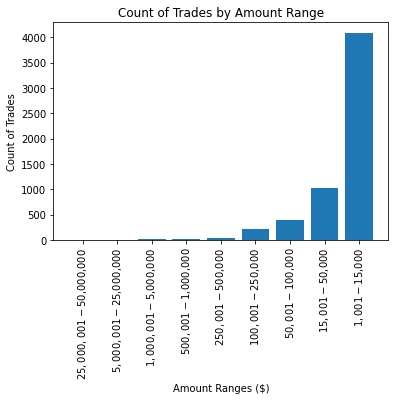

In [16]:
plt.ylabel("Count of Trades")
plt.xlabel("Amount Ranges ($)")
plt.xticks(rotation=90)
plt.title("Count of Trades by Amount Range")
plt.bar(amount_count.index, amount_count)

The column for the smallest trade range completely dwarfs the other columns! Maybe we can use logarithmic scaling to make this easier to visualize.

<BarContainer object of 9 artists>

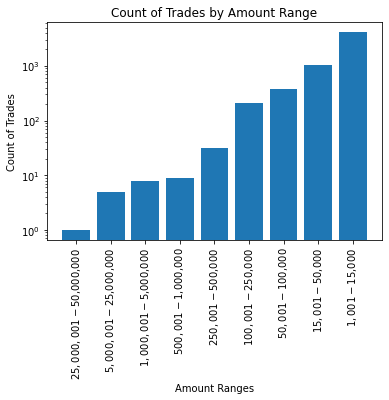

In [17]:
plt.ylabel("Count of Trades")
plt.xlabel("Amount Ranges")
plt.xticks(rotation=90)
plt.title("Count of Trades by Amount Range")
plt.bar(amount_count.index, amount_count, log=True)

This is really interesting. It seems like each step up in amount has an order of magnitude less trades. It would be interesting to see if this is a result of the distribution of wealth among the members of the senate, or a result of disclosure regulations pushing senators to trade in a lower bracket.

Now, we can look at the kinds of transactions that senators made.

In [18]:
type_group = data.groupby("type")
type_group.count()["owner"]

type
Exchange            66
Purchase          2880
Sale (Full)       1411
Sale (Partial)    1397
Name: owner, dtype: int64

The `Exchange` type would be in the case of mergers and other stock exchanges.

It seems like senators will often not sell their stocks completely (the `Sale (Full)` Column). Instead, they seem to sell a percentage of their holdings instead of completely pulling out.


In [19]:
owner_group = data.groupby("owner")
owner_count = owner_group.count()["senator"]
owner_count

owner
Child      120
Joint     2917
Self       888
Spouse    1829
Name: senator, dtype: int64

We can also see that a lot of trades are not actually made by the senator themselves. A few of them are made by children of the officeholder, but the majority are joint purchases, presumably between the senator and their spouse. This data could be visualized clearly by a pie-chart.

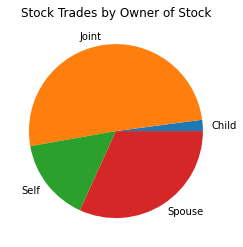

In [20]:
plt.title("Stock Trades by Owner of Stock")
plt.pie(owner_count, labels=owner_count.index);

Since we have lots of ticker data, we can see which companies were preferred by senators in their investments.

In [21]:
ticker_group = data.groupby(["ticker"])
ticker_count = ticker_group.count().sort_values("amount", ascending=False)["owner"]
ticker_count.head(10)

ticker
AAPL     149
BAC       79
DISCA     74
PFE       74
DIS       71
NFLX      68
MSFT      67
FDC       66
URBN      65
FEYE      65
Name: owner, dtype: int64

It looks like Apple was favored heavily throughout the years. But what if we break down the data into each year. What will Apple's ranking be for each year.

In [22]:
for year in range(2012, 2022):
  temp = data[data['transaction_year'] == year].groupby(["ticker"]).count().sort_values("amount", ascending=False)["owner"].reset_index()
  print("AAPL Ranking for {}: {}".format(year, temp[temp["ticker"] == "AAPL"].index[0] + 1 if len(temp[temp["ticker"] == "AAPL"]) != 0 else -1))

AAPL Ranking for 2012: -1
AAPL Ranking for 2013: -1
AAPL Ranking for 2014: -1
AAPL Ranking for 2015: 5
AAPL Ranking for 2016: 3
AAPL Ranking for 2017: 7
AAPL Ranking for 2018: 4
AAPL Ranking for 2019: 6
AAPL Ranking for 2020: 1
AAPL Ranking for 2021: 2


While `AAPL` was not in the rankings in the first three years, it consistently made the top ten every year after that. While it was only the most traded stock in 2020, it seems to be an overall favorite for senators year after year.

We can also look at data for each senator. Let's graph which senators traded the most.

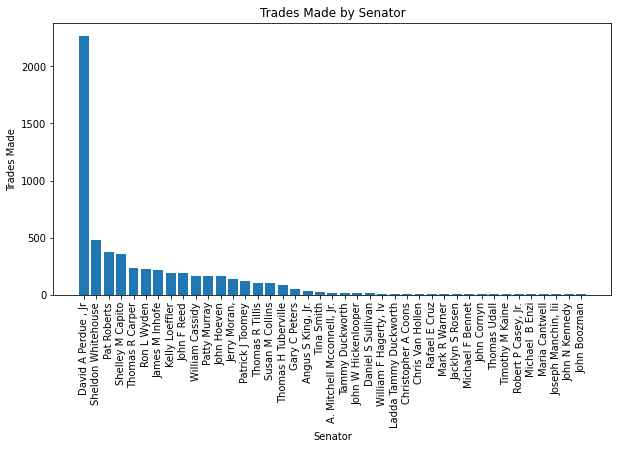

In [36]:
senators_grouped = data.groupby("senator")
senator_count = senators_grouped.count().sort_values("owner", ascending=False)["owner"]

plt.figure(figsize=(10, 5))
plt.ylabel("Trades Made")
plt.xlabel("Senator")
plt.title("Trades Made by Senator")
plt.xticks(rotation=90)
plt.bar(senator_count.index, senator_count, width=0.8);

It is important to note that not every senator has held office throughout the date range that this dataset covers. Therefore, the conclusions we can draw from this are limited. Regardless, we see that Senator David A. Perdue Jr. has traded far more than every other member of the senate, far more than just the number of years he has held office.

We can also look at the median amounts that each senator traded. We will use the median rather than the mean because we are interested in what magnitudes of trades are most common rather than the average amount in a trade. Single, large-value trades could easily sway our results if we use the mean.

In [37]:
data.loc[data.type == "Purchase"].groupby(data.senator).median().sort_values("amount_lower", ascending=False)["amount_lower"].head(10)

senator
Kelly Loeffler                100001.0
Rafael E Cruz                  50001.0
Tina Smith                     50001.0
James M Inhofe                 50001.0
John Hoeven                    50001.0
Joseph Manchin, Iii            50001.0
John Cornyn                    15001.0
Susan M Collins                15001.0
Ron L Wyden                    15001.0
A. Mitchell Mcconnell, Jr.      1001.0
Name: amount_lower, dtype: float64

We can see that Kelly Loeffler makes more high-value trades than other members. A number of other members also make high trades, but the vast majority of members make lower-valued trades, including Perdue, who made far more trades than any other senator. Quantity vs. Quality?

#### House SEC Filings


In order to expand the scope of our dataset, we will begin analyzing data on the House. Perhaps there will be data that is even more clear given that representatives in the House should be more *representative* of the people. Let's show the first few rows of the dataset.

In [ ]:
house.head()

In [ ]:
house_amount_group = house.groupby("amount")
house_amount_count = house_amount_group.count().sort_values("owner")["owner"]
house_amount_count

Hmmm...it appears as though there are some strange, overlapping data. We'll perform some basic transformations to combine these overlapping data.

In [ ]:
house[house["amount"] == "$1,000 - $15,000"] = "$1,001 - $15,000"
house[house["amount"] == "$15,000 - $50,000"] = "$15,001 - $50,000"
house[house["amount"] == "$1,001 -"] = "$1,001 - $15,000"

house_amount_group = house.groupby("amount")
house_amount_count = house_amount_group.count().sort_values("owner")["owner"]
house_amount_count

Now that the amounts seem to all be regular, it's time to perform some basic analysis on our House dataset! We can begin by graphing out the various amounts to visualize them better.

In [ ]:
plt.ylabel("Count of Trades")
plt.xlabel("Amount Ranges ($)")
plt.xticks(rotation=90)
plt.title("Count of Trades by Amount Range (House)")
plt.bar(house_amount_count.index, house_amount_count)
plt.show()

Similar to in the Senate data, the lowest value bracket dwarfs all the other bars. We'll have to use a logarithmic scale to better visualize our data here.

In [ ]:
plt.ylabel("Count of Trades")
plt.xlabel("Amount Ranges ($)")
plt.xticks(rotation=90)
plt.title("Count of Trades by Amount Range (House)")
plt.bar(house_amount_count.index, house_amount_count, log = True)
plt.show()

We're curious to see just how profitable some of these trades are for House Representatives. Let's look at how many of each of the ranges yield gains for Representatives that are over $200 USD as is described in the `cap_gains_over_200_usd` column.

In [ ]:
over_200_house = house[house["cap_gains_over_200_usd"] == True]
grouped_over_200 = over_200_house.groupby("amount")

over_200_count = grouped_over_200.count().sort_values("owner")["owner"]
over_200_count

Interesting, it'll be easier to visualize once graphed out.

In [ ]:


plt.ylabel("Count of Trades over $200")
plt.xlabel("Amount Ranges ($)")
plt.xticks(rotation=90)
plt.title("Count of Trades over $200 by Amount Range (House)")
plt.bar(over_200_count.index, over_200_count)
plt.show()

Huh, though upon initial inspection one might conclude that the lower ranges are far more profitable, perhaps this is a product of there simply being fewer trades in the higher brackets. Let's use to proportions to see this properly.

In [ ]:
proportions = [over_200_count[i] / house_amount_count[i+1] for i in range(len(over_200_count))]

plt.ylabel("Proportion of Gains over $200")
plt.xlabel("Amount Ranges ($)")
plt.xticks(rotation=90)
plt.title("Proportion of Gains over $200 by Amount Range (House)")
plt.bar(over_200_count.index, proportions)
plt.show()

Now this yields a very interesting output. It appears as though there is a weak, but still notable positive correlation between the value of Representatives' trades and proportion of gains over $200. This could be a product of similar proportions of gains relative to the amount of money traded, or it could be that individuals trade more money on stocks that will give greater returns.

#### Senator Data

Let's take a look at the senators who have filed their trades, and explore how that relates to their trading habits. We can start by grouping senators by their gender, political party, and senate class.

*Senate Class comes from a provision in the U.S. Constitution which states that no more than one-third of the Senate may be up for election at a time. Therefore, the senate is divided into 3 "classes" which just determines when the senators will be up for re-election.*

First let's look at Gender.

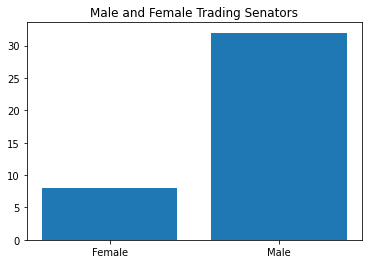

In [38]:
gender_group = trading_senators.groupby("gender")
plt.title("Male and Female Trading Senators")
plt.bar(["Female", "Male"], gender_group.count()["name"]);

However, this could just be a result of there being fewer female members of congress. Regardless, it is important to note that our data is very male-dominated. 

Now let's look at political party.

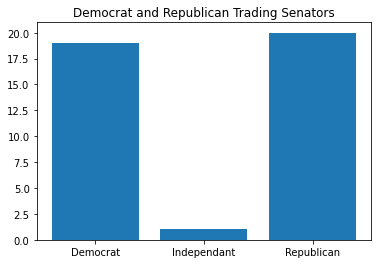

In [39]:
party_group = trading_senators.groupby("party")
plt.title("Democrat and Republican Trading Senators")
plt.bar(["Democrat", "Independant", "Republican"], party_group.count()["name"]);

It looks like there is an (almost) 50/50 split between Democrats and Republicans that trade, with one Independant senator who also trades. While people may assume that one party trades more frequently than the other, it seems like the activity is equally as common. It would be interesting to see how this data compares to the actual makeup of the Senate during the time periods referenced.

Finally, we can look at Senate Class, although I don't expect there to be any trend here considering the meaning of Senate Class.

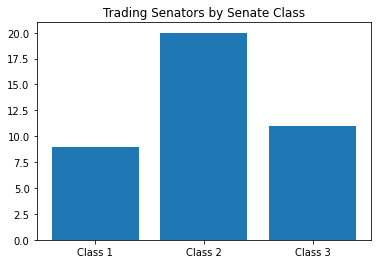

In [40]:
class_group = trading_senators.groupby("senate_class")
plt.title("Trading Senators by Senate Class")
plt.bar(["Class 1", "Class 2", "Class 3"], class_group.count()["name"]);

Surprisingly, there appears to be a big difference between the senators in Class 2, and the senators in other classes. Maybe this is something to look into further. Perhaps there is a deeper implication here with the way that senators are assigned to classes.

### Questions for Reviewers
- Do these questions sounds viable for a final project?
- Do you have any suggestions for potential hypotheses that we can examine within this data?
- Is this data enough for a conclusive final project, or would you recomend drawing on more data?